In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

print("TensorFlow version:", tf.__version__)
print("MediaPipe version:", mp.__version__)

Mounted at /content/drive
TensorFlow version: 2.18.0
MediaPipe version: 0.10.21


In [ ]:
DATA_DIR = './dataset/BISINDO'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_LANDMARKS = 21 * 3 # 21 landmarks, masing-masing dengan x, y, z

# --- INISIALISASI MEDIAPIPE ---
mp_hands = mp.solutions.hands
hands_model = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# --- FUNGSI GENERATOR DATA ---
CLASS_NAMES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(CLASS_NAMES)
class_to_int = {label: i for i, label in enumerate(CLASS_NAMES)}

def data_generator():
    """Generator untuk menghasilkan gambar, landmark, dan label."""
    for label_name in CLASS_NAMES:
        label_dir = os.path.join(DATA_DIR, label_name)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)

            # Proses Gambar untuk CNN
            try:
                image = tf.io.read_file(image_path)
                image = tf.image.decode_jpeg(image, channels=3)
                image = tf.image.resize(image, IMAGE_SIZE)
            except Exception as e:
                print(f"Skipping image due to error: {image_path}, {e}")
                continue

            # Proses Landmark untuk MLP
            cv_image = cv2.imread(image_path)
            if cv_image is None: continue
            cv_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
            results = hands_model.process(cv_image_rgb)

            landmarks_vector = np.zeros(NUM_LANDMARKS, dtype=np.float32)
            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                base_point = coords[0]
                relative_coords = coords - base_point
                landmarks_vector = relative_coords.flatten()

            # Yield Data dalam format dictionary untuk input multi-cabang
            yield {'image_input': image, 'landmark_input': landmarks_vector}, class_to_int[label_name]

print(f"Ditemukan {NUM_CLASSES} kelas: {CLASS_NAMES}")

Ditemukan 26 kelas: ['A (1)', 'B (1)', 'C (1)', 'D (1)', 'E (1)', 'F (1)', 'G (1)', 'H (1)', 'I (1)', 'J', 'K (1)', 'L (1)', 'M (1)', 'N (1)', 'O (1)', 'P (1)', 'Q (1)', 'R (1)', 'S (1)', 'T (1)', 'U (1)', 'V (1)', 'W (1)', 'X (1)', 'Y (1)', 'Z']


In [ ]:
# Tentukan signature output dari generator kita
output_signature = (
    {'image_input': tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
     'landmark_input': tf.TensorSpec(shape=(NUM_LANDMARKS,), dtype=tf.float32)},
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

# Buat dataset dari generator
dataset = tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)

# Hitung ukuran dataset untuk splitting
DATASET_SIZE = sum([len(files) for r, d, files in os.walk(DATA_DIR)])
train_size = int(0.8 * DATASET_SIZE)
val_size = DATASET_SIZE - train_size

# Shuffle dan split dataset
dataset = dataset.shuffle(buffer_size=1024)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

# Terapkan batching, caching, dan prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

print("Pipeline data training dan validasi telah siap.")

Pipeline data training dan validasi telah siap.


In [ ]:
# --- Cabang 1: Visual (CNN) ---
input_image = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
rescaling = tf.keras.layers.Rescaling(1./255)(input_image)
base_model_cnn = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=rescaling)
base_model_cnn.trainable = False
visual_features = GlobalAveragePooling2D()(base_model_cnn.output)

# --- Cabang 2: Landmark (MLP) ---
input_landmarks = Input(shape=(NUM_LANDMARKS,), name='landmark_input')
x = Dense(128, activation='relu')(input_landmarks)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
landmark_features = Dense(32, activation='relu')(x)

# --- Menggabungkan Kedua Cabang ---
combined_features = Concatenate()([visual_features, landmark_features])

# --- Classifier Akhir ---
x = Dropout(0.5)(combined_features)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# --- Membuat Model Akhir ---
model = Model(inputs=[input_image, input_landmarks], outputs=output, name='Hybrid_Sign_Language_Model')

# --- Kompilasi Model ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Hybrid_Sign_Language_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,102,237 (15.65 MB)

 Trainable params: 52,666 (205.73 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Memulai proses training awal...
Epoch 1/200
    131/Unknown 348s 2s/step - accuracy: 0.1204 - loss: 3.0176

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


131/131 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.1204 - loss: 3.0199 - val_accuracy: 0.2198 - val_loss: 3.3960
Epoch 2/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2826 - loss: 2.6003 - val_accuracy: 0.3177 - val_loss: 2.2410
Epoch 3/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4141 - loss: 1.7967 - val_accuracy: 0.4885 - val_loss: 1.8047
Epoch 4/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5064 - loss: 1.4739 - val_accuracy: 0.5010 - val_loss: 1.6136
Epoch 5/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5903 - loss: 1.1996 - val_accuracy: 0.5835 - val_loss: 1.4482
Epoch 6/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6200 - loss: 1.1206 - val_accuracy: 0.5883 - val_loss: 1.3437
Epoch 7/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6379 - loss: 1.0384 - val_accuracy: 0.6142 - val_loss: 1.2927
Epoch 8/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6904 - loss: 0.8919 - val_accuracy

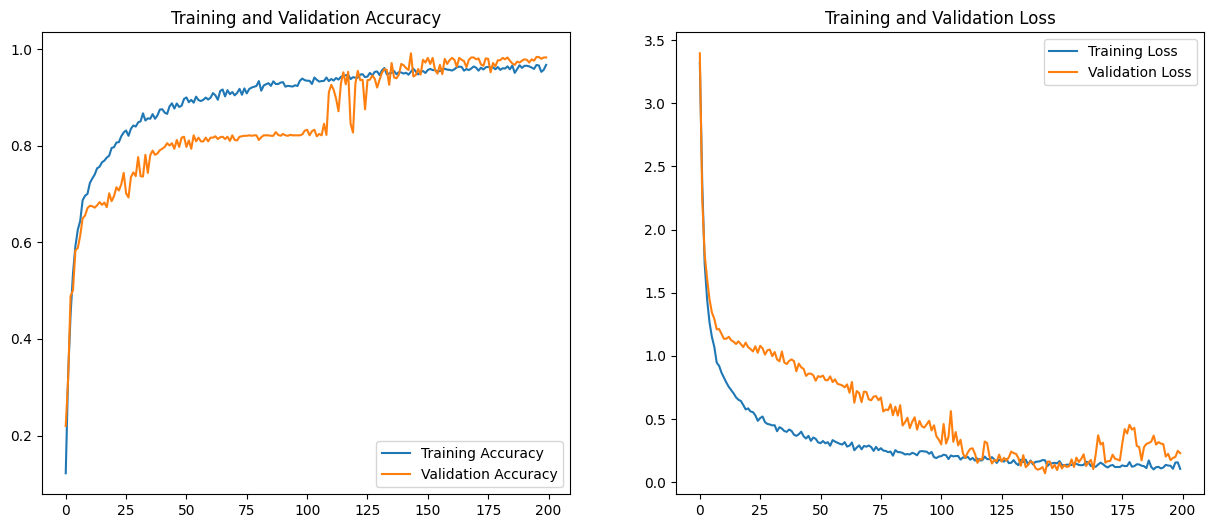

In [ ]:
EPOCHS = 200

print("Memulai proses training awal...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    verbose=1
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_model_cnn.trainable = True
fine_tune_at = 150
for layer in base_model_cnn.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model siap untuk di-fine-tune.")
model.summary()

Model siap untuk di-fine-tune.


Model: "Hybrid_Sign_Language_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,102,237 (15.65 MB)

 Trainable params: 3,341,714 (12.75 MB)

 Non-trainable params: 760,523 (2.90 MB)

Memulai proses fine-tuning...
Epoch 200/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 244ms/step - accuracy: 0.4875 - loss: 5.1812 - val_accuracy: 0.9578 - val_loss: 0.5330
Epoch 201/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 328ms/step - accuracy: 0.6570 - loss: 1.5255 - val_accuracy: 0.7083 - val_loss: 1.0610
Epoch 202/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7966 - loss: 0.6920 - val_accuracy: 0.8369 - val_loss: 0.6650
Epoch 203/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8674 - loss: 0.4052 - val_accuracy: 0.9597 - val_loss: 0.4793
Epoch 204/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9207 - loss: 0.2384 - val_accuracy: 0.9731 - val_loss: 0.4287
Epoch 205/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9193 - loss: 0.2558 - val_accuracy: 0.9770 - val_loss: 0.3946
Epoch 206/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9423 - loss: 0.1744 - val_accuracy: 0.9789 - val_loss: 0.3729
Epoch 207/300
131/131 ━━━━━━━━━━━━━━━━━━━━

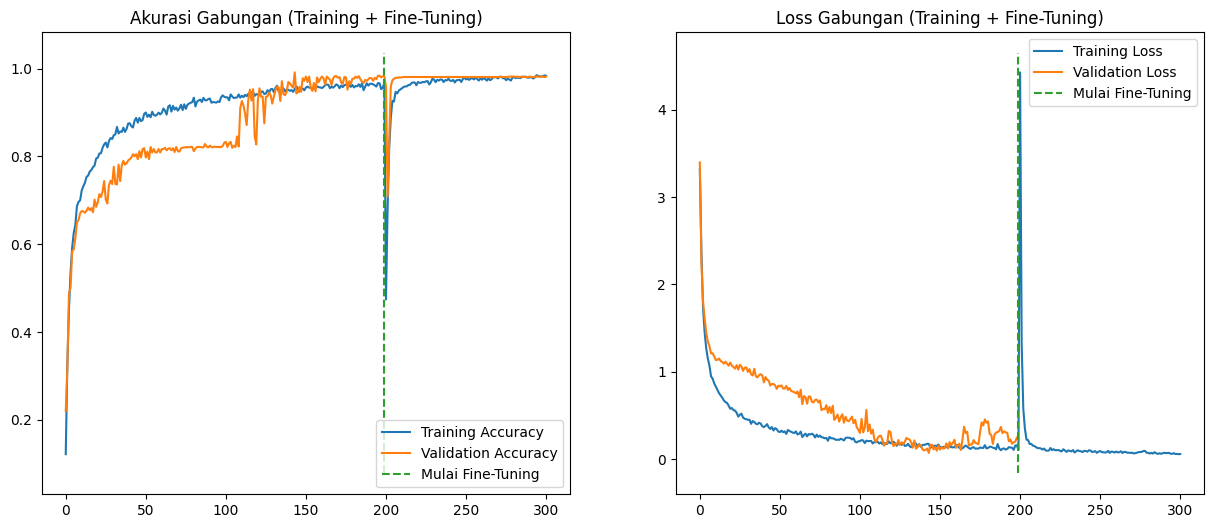

In [ ]:
fine_tune_epochs = 100 # Latih untuk 10 epoch tambahan
total_epochs = EPOCHS + fine_tune_epochs

print("Memulai proses fine-tuning...")
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Melanjutkan dari epoch terakhir
    validation_data=validation_dataset,
    verbose=1
)

# Gabungkan history dari training awal dan fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Mulai Fine-Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Akurasi Gabungan (Training + Fine-Tuning)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Mulai Fine-Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Loss Gabungan (Training + Fine-Tuning)')
plt.show()

In [ ]:
model.save('sibi_hybrid_model_v2_finetuned.keras')
print("Model hasil fine-tuning berhasil disimpan sebagai 'sibi_hybrid_model_v2_finetuned.keras'")

Model hasil fine-tuning berhasil disimpan sebagai 'sibi_hybrid_model_v2_finetuned.keras'
